In [ ]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [ ]:
!pip install keras_applications==1.0.8

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.2 MB/s eta 0:00:00


In [ ]:
!pip install segmentation-models-3D==1.0.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.6/69.6 kB 4.1 MB/s eta 0:00:00


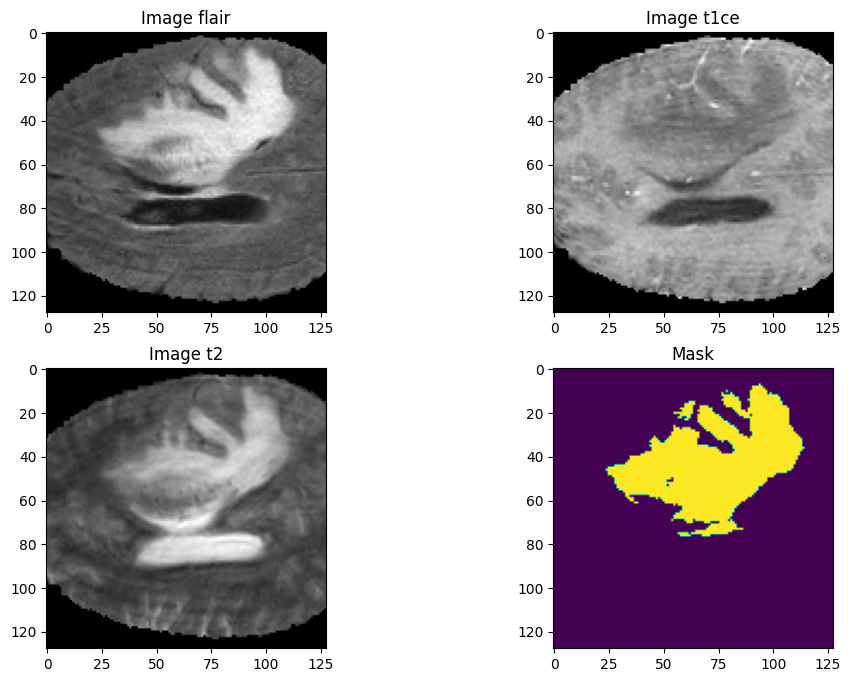

In [ ]:
# https://youtu.be/PNqnLbzdxwQ
"""
Custom data generator to work with BraTS2020 dataset.
Can be used as a template to create your own custom data generators.

No image processing operations are performed here, just load data from local directory
in batches.

"""

#from tifffile import imsave, imread
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):
        if (image_name.split('.')[1] == 'npy'):
            image = np.load(img_dir + image_name)
            images.append(image)
    images = np.array(images)

    # Print the shape of loaded images
    #print("Loaded images shape:", images.shape)

    return images

def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):
    L = len(img_list)

    while True:
        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)

            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            # Print shapes of X (images) and Y (masks)
            #print("X shape:", X.shape)
            #print("Y shape:", Y.shape)

            yield (X, Y)

            batch_start += batch_size
            batch_end += batch_size
############################################

#Test the generator

from matplotlib import pyplot as plt
import random

train_img_dir = "/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/train/masks/"
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

batch_size = 1

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [ ]:
import tensorflow as tf
import tensorflow.keras as k
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, Dropout

def conv_block(x, kernels, kernel_size=(3, 3, 3), strides=(1, 1, 1), padding='same',
               is_bn=True, is_relu=True, n=2):
    """ Custom function for conv3D:
        Apply 3*3 convolutions with BN and relu.
    """
    for i in range(1, n + 1):
        x = k.layers.Conv3D(filters=kernels, kernel_size=kernel_size,
                            padding=padding, strides=strides,
                            kernel_regularizer=tf.keras.regularizers.l2(1e-4),
                            kernel_initializer=k.initializers.he_normal(seed=5))(x)
        if is_bn:
            x = k.layers.BatchNormalization()(x)
        if is_relu:
            x = k.activations.relu(x)
    return x
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))

    # Encoder
    filters = [4, 8, 16, 32, 64]
    #filters = [64, 128, 256, 512, 1024]
    input_shape = [IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS]
    output_channels=  num_classes
    input_layer = k.layers.Input(
        shape=input_shape,
        name="input_layer"
    )  # 320*320*3

    """ Encoder"""
    # block 1
    e1 = conv_block(input_layer, filters[0])  # 320*320*64

    # block 2
    e2 = k.layers.MaxPool3D(pool_size=(2, 2,2))(e1)  # 160*160*64
    e2 = conv_block(e2, filters[1])  # 160*160*128

    # block 3
    e3 = k.layers.MaxPool3D(pool_size=(2, 2,2))(e2)  # 80*80*128
    e3 = conv_block(e3, filters[2])  # 80*80*256

    # block 4
    e4 = k.layers.MaxPool3D(pool_size=(2, 2,2))(e3)  # 40*40*256
    e4 = conv_block(e4, filters[3])  # 40*40*512

    # block 5
    # bottleneck layer
    e5 = k.layers.MaxPool3D(pool_size=(2, 2,2))(e4)  # 20*20*512
    e5 = conv_block(e5, filters[4])  # 20*20*1024

    """ Decoder """
    cat_channels = filters[0]
    cat_blocks = len(filters)
    upsample_channels = cat_blocks * cat_channels

    """ d4 """
    e1_d4 = k.layers.MaxPool3D(pool_size=(8, 8,8))(e1)  # 320*320*64  --> 40*40*64
    e1_d4 = conv_block(e1_d4, cat_channels, n=1)  # 320*320*64  --> 40*40*64

    e2_d4 = k.layers.MaxPool3D(pool_size=(4, 4,4))(e2)  # 160*160*128 --> 40*40*128
    e2_d4 = conv_block(e2_d4, cat_channels, n=1)  # 160*160*128 --> 40*40*64

    e3_d4 = k.layers.MaxPool3D(pool_size=(2, 2,2))(e3)  # 80*80*256  --> 40*40*256
    e3_d4 = conv_block(e3_d4, cat_channels, n=1)  # 80*80*256  --> 40*40*64

    e4_d4 = conv_block(e4, cat_channels, n=1)  # 40*40*512  --> 40*40*64

    e5_d4 = k.layers.UpSampling3D(size=(2, 2,2))(e5)  # 80*80*256  --> 40*40*256
    e5_d4 = conv_block(e5_d4, cat_channels, n=1)  # 20*20*1024  --> 20*20*64

    d4 = k.layers.concatenate([e1_d4, e2_d4, e3_d4, e4_d4, e5_d4], axis=-1)
    d4 = conv_block(d4, upsample_channels, n=1)  # 40*40*320  --> 40*40*320

    """ d3 """
    e1_d3 = k.layers.MaxPool3D(pool_size=(4, 4,4))(e1)  # 320*320*64 --> 80*80*64
    e1_d3 = conv_block(e1_d3, cat_channels, n=1)  # 80*80*64 --> 80*80*64

    e2_d3 = k.layers.MaxPool3D(pool_size=(2, 2,2))(e2)  # 160*160*256 --> 80*80*256
    e2_d3 = conv_block(e2_d3, cat_channels, n=1)  # 80*80*256 --> 80*80*64

    e3_d3 = conv_block(e3, cat_channels, n=1)  # 80*80*512 --> 80*80*64

    e4_d3 = k.layers.UpSampling3D(size=(2, 2,2))(d4)  # 40*40*320 --> 80*80*320
    e4_d3 = conv_block(e4_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    e5_d3 = k.layers.UpSampling3D(size=(4, 4,4))(e5)  # 20*20*320 --> 80*80*320
    e5_d3 = conv_block(e5_d3, cat_channels, n=1)  # 80*80*320 --> 80*80*64

    d3 = k.layers.concatenate([e1_d3, e2_d3, e3_d3, e4_d3, e5_d3], axis=-1)
    d3 = conv_block(d3, upsample_channels, n=1)  # 80*80*320 --> 80*80*320

    """ d2 """
    e1_d2 = k.layers.MaxPool3D(pool_size=(2, 2,2))(e1)  # 320*320*64 --> 160*160*64
    e1_d2 = conv_block(e1_d2, cat_channels, n=1)  # 160*160*64 --> 160*160*64

    e2_d2 = conv_block(e2, cat_channels, n=1)  # 160*160*256 --> 160*160*64

    d3_d2 = k.layers.UpSampling3D(size=(2, 2,2))(d3)  # 80*80*320 --> 160*160*320
    d3_d2 = conv_block(d3_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d4_d2 = k.layers.UpSampling3D(size=(4, 4,4))(d4)  # 40*40*320 --> 160*160*320
    d4_d2 = conv_block(d4_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    e5_d2 = k.layers.UpSampling3D(size=(8, 8,8))(e5)  # 20*20*320 --> 160*160*320
    e5_d2 = conv_block(e5_d2, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d2 = k.layers.concatenate([e1_d2, e2_d2, d3_d2, d4_d2, e5_d2], axis=-1)
    d2 = conv_block(d2, upsample_channels, n=1)  # 160*160*320 --> 160*160*320

    """ d1 """
    e1_d1 = conv_block(e1, cat_channels, n=1)  # 320*320*64 --> 320*320*64

    d2_d1 = k.layers.UpSampling3D(size=(2, 2,2))(d2)  # 160*160*320 --> 320*320*320
    d2_d1 = conv_block(d2_d1, cat_channels, n=1)  # 160*160*320 --> 160*160*64

    d3_d1 = k.layers.UpSampling3D(size=(4, 4,4))(d3)  # 80*80*320 --> 320*320*320
    d3_d1 = conv_block(d3_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d4_d1 = k.layers.UpSampling3D(size=(8, 8,8))(d4)  # 40*40*320 --> 320*320*320
    d4_d1 = conv_block(d4_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    e5_d1 = k.layers.UpSampling3D(size=(16, 16,16))(e5)  # 20*20*320 --> 320*320*320
    e5_d1 = conv_block(e5_d1, cat_channels, n=1)  # 320*320*320 --> 320*320*64

    d1 = k.layers.concatenate([e1_d1, d2_d1, d3_d1, d4_d1, e5_d1, ], axis=-1)
    d1 = conv_block(d1, upsample_channels, n=1)  # 320*320*320 --> 320*320*320

    # last layer does not have batchnorm and relu
    d = conv_block(d1, output_channels, n=1, is_bn=False, is_relu=False)
    output = k.activations.softmax(d)

    return tf.keras.Model(inputs=input_layer, outputs=[output], name='UNet_3Plus')

#Test if everything is working ok.
#model = simple_unet_model(128, 128, 128, 3, 4)
model =simple_unet_model(128,128,128,3,4)
model.summary()
print(model.input_shape)
print(model.output_shape)

In [ ]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
def get_flops(model):
    concrete_func = tf.function(model).get_concrete_function(
        [tf.TensorSpec([1, *inp.shape[1:]]) for inp in model.inputs])
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name='')
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

        return flops.total_float_ops


# Calculate FLOPS
flops = get_flops(model)
print(f"FLOPS: {flops}")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPS: 132156981248


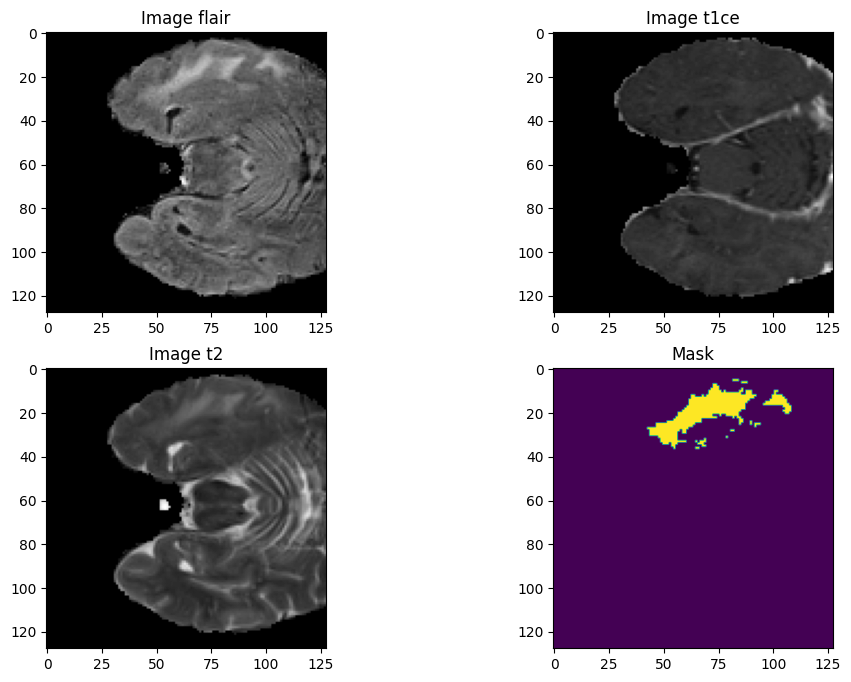

"\nimport pandas as pd\ncolumns = ['0','1', '2', '3']\ndf = pd.DataFrame(columns=columns)\ntrain_mask_list = sorted(glob.glob('/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))\nfor img in range(len(train_mask_list)):\n    print(img)\n    temp_image=np.load(train_mask_list[img])\n    temp_image = np.argmax(temp_image, axis=3)\n    val, counts = np.unique(temp_image, return_counts=True)\n    zipped = zip(columns, counts)\n    conts_dict = dict(zipped)\n\n    df = df.append(conts_dict, ignore_index=True)\n\nlabel_0 = df['0'].sum()\nlabel_1 = df['1'].sum()\nlabel_2 = df['1'].sum()\nlabel_3 = df['3'].sum()\ntotal_labels = label_0 + label_1 + label_2 + label_3\nn_classes = 4\n#Class weights claculation: n_samples / (n_classes * n_samples_for_class)\nwt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals\nwt1 = round((total_labels/(n_classes*label_1)), 2)\nwt2 = round((total_labels/(n_classes*label_2)), 2)\nwt3 = round((tot

In [ ]:
import os
import numpy as np
#from custom_datagen.py import imageLoader
import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
import tensorflow as tf


####################################################
train_img_dir = "/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])#here
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

#############################################################
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25
'''
import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)

    df = df.append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss
'''


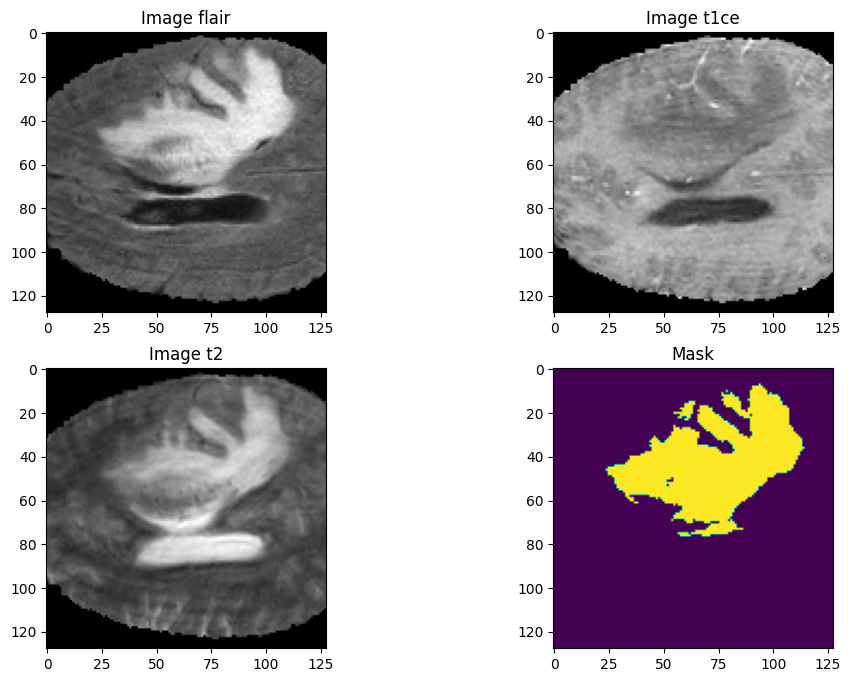

In [ ]:
##############################################################
#Define the image generators for training and validation

train_img_dir = "/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
##################################

########################################################################
batch_size = 1                                    #Changed here from 2 to 1

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

(None, 128, 128, 128, 3)
(None, 128, 128, 128, 4)
Epoch 1/10
275/275 [==============================] - 560s 2s/step - loss: 0.9367 - accuracy: 0.9590 - iou_score: 0.4493 - val_loss: 0.9783 - val_accuracy: 0.9107 - val_iou_score: 0.3556
Epoch 2/10
275/275 [==============================] - 549s 2s/step - loss: 0.8844 - accuracy: 0.9735 - iou_score: 0.5452 - val_loss: 0.9299 - val_accuracy: 0.9326 - val_iou_score: 0.4345
Epoch 3/10
275/275 [==============================] - 493s 2s/step - loss: 0.8679 - accuracy: 0.9759 - iou_score: 0.5741 - val_loss: 0.9258 - val_accuracy: 0.9339 - val_iou_score: 0.4277
Epoch 4/10
275/275 [==============================] - 539s 2s/step - loss: 0.8590 - accuracy: 0.9773 - iou_score: 0.5917 - val_loss: 0.9118 - val_accuracy: 0.9370 - val_iou_score: 0.4715
Epoch 5/10
275/275 [==============================] - 539s 2s/step - loss: 0.8530 - accuracy: 0.9784 - iou_score: 0.6046 - val_loss: 0.9066 - val_accuracy: 0.9425 - val_iou_score: 0.4710
Epoch 6/10
275/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


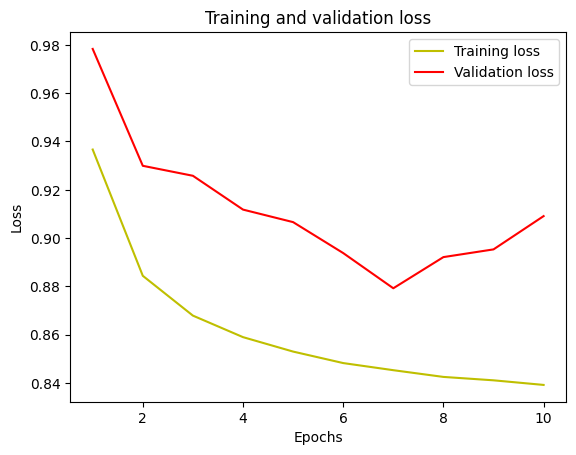

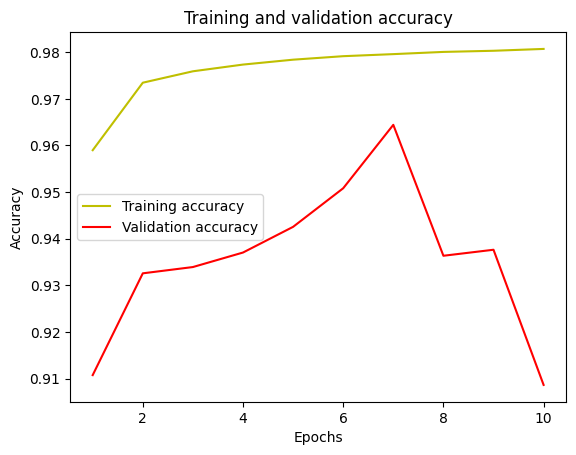

In [ ]:
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.001#changed here og=0.0001
#optim = tf.keras.optimizers.Adam(LR)
optim=tf.keras.optimizers.experimental.Nadam(LR)
#######################################################################
#Fit the model

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


#from  simple_3d_unet.py import simple_unet_model
model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
#print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,#chaned here
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
model.save('brats_3d.hdf5')
##################################################################


#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#################################################


In [ ]:
print(loss)
print(val_loss)

[0.9366683959960938, 0.8843806385993958, 0.8678993582725525, 0.8589868545532227, 0.8530067205429077, 0.8482478857040405, 0.8453010320663452, 0.8425139784812927, 0.8411056995391846, 0.839199423789978]
[0.978333055973053, 0.9299342036247253, 0.9258023500442505, 0.9118003845214844, 0.9066122770309448, 0.8937988877296448, 0.879224956035614, 0.8921268582344055, 0.8953204154968262, 0.9091050028800964]


In [ ]:
from keras.models import load_model

#Load model for prediction or continue training
'''
#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and
#continue training we need to provide these as custom_objects.
my_model = load_model('/content/brats_3d.hdf5')

#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score
my_model = load_model('/content/brats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss})
'''
#Now, let us add the iou_score function we used during our initial training
my_model = load_model('/content/brats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

#Now all set to continue the training process.
history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=1,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )
#################################################

#For predictions you do not need to compile the model, so ...
my_model = load_model('/content/brats_3d.hdf5',
                      compile=False)


#Verify IoU on a batch of images from the test dataset
#Using built in keras function for IoU
#Only works on TF > 2.0

275/275 [==============================] - 607s 2s/step - loss: 0.8388 - accuracy: 0.9807 - iou_score: 0.6371 - val_loss: 0.8930 - val_accuracy: 0.9517 - val_iou_score: 0.4831


1/1 [==============================] - 0s 219ms/step
Mean IoU = 0.6371522
1/1 [==============================] - 0s 41ms/step
(128, 128, 128)
(128, 128, 128)
[0 1 2 3]


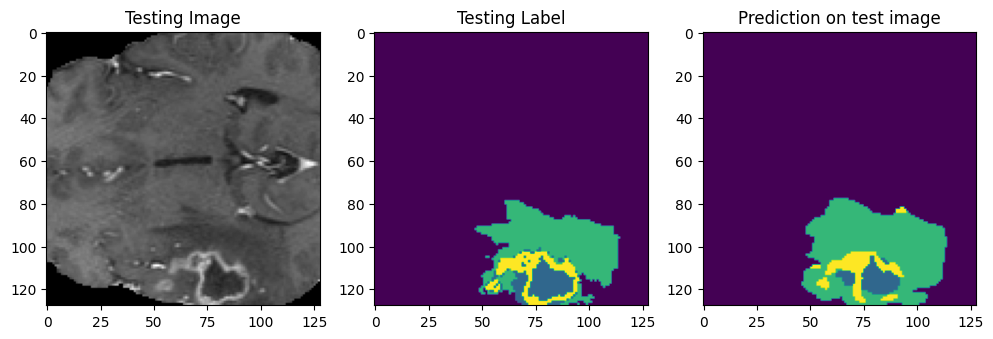

In [ ]:
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#############################################
#Predict on a few test images, one at a time
#Try images:
img_num = 16

test_img = np.load("/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("/content/drive/MyDrive/My_code_3DUnet3plus/BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


print(test_prediction_argmax.shape)
print(test_mask_argmax.shape)
print(np.unique(test_prediction_argmax))

#Plot individual slices from test predictions for verification
from matplotlib import pyplot as plt
import random

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

############################################################